# Laboratoire 1: Introduction au Deep learning

Le but de se laboratoire est de se familiariser avec Pytorch en l'utilisant pour faire du classement sur deux jeux de données connus: MNIST et CIFAR-10.

## Mnist

In [1]:
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
%matplotlib inline

from deeplib.datasets import load_mnist, load_cifar10, Dataset
from sklearn.metrics import accuracy_score
from deeplib.net import MnistNet, CifarNet
from deeplib.history import History

Mnist est jeu de données contenant des images de chiffres manuscrits.<br>
Le jeu de donnée est séparé comme suit: 50000 images sont utilisées en entraînement et 10000 en test.<br> 
Afin d'accélérer les calculs, nous commencerons par charger uniquement 1000 images pour l'entraînement.<br>
Nous allons aussi charger 1000 autres images pour créer un ensemble de validation qui nous permettra d'estimer, pendant l'entraînement, les capacités de généralisation de notre modèle.

In [2]:
mnist = load_mnist()
train_set = Dataset(mnist[:1000])
val_set = Dataset(mnist[1000:2000])
test_set = load_mnist(train=False)

Vous pouvez exécuter cette cellule plusieurs fois pour bien visualiser le jeu de donnée.

Target = 3


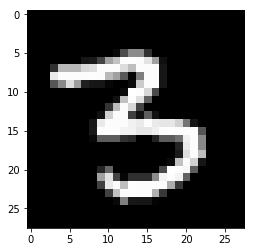

In [4]:
i = random.randrange(0, len(train_set))
img, target = train_set[i]
plt.imshow(np.asarray(img), cmap='gray')
print('Target = {}'.format(target))

## Entraînement

Pour l'entraînement, nous avons besoin d'une fonction validate qui nous permettra d'estimer la performance de notre modèle et d'une fonction train pour faire l'entraînement.

Pour chaque image du jeu de donnée, la fonction validate fait prédire une classe au réseau entraîné et compare le résultat avec la vraie réponse. Elle retourne le pourcentage de réponse correcte.

In [5]:
def validate(model, dataset, use_gpu=False):
    true =[]
    pred = []
    val_loss = []
    criterion = nn.CrossEntropyLoss()
    for j in range(len(dataset) // batch_size):
        inputs, targets = dataset.get_mini_batch(batch_size, use_gpu)
        output = model(inputs)
        val_loss.append(criterion(output, targets).data[0])
        predictions = output.max(dim=1)[1]
        true.extend(targets.data.cpu().numpy().tolist())
        pred.extend(predictions.data.cpu().numpy().tolist())

    return accuracy_score(true, pred) * 100, sum(val_loss) / len(val_loss)

Pour chaque epoch, la fonction passe au travers de toutes les images du jeu de donnée et met à jour les poids du réseau selon la perte calculée. On sauvegarde aussi quelques informations importantes afin de visualiser ce qui se passe pendant l'entraînement.

In [6]:
def train(model, n_epoch, batch_size, lr, use_gpu=False):
    history = History()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    for i in range(n_epoch):
        for j in range(len(train_set) // batch_size):
            inputs, targets = train_set.get_mini_batch(batch_size, use_gpu)
            optimizer.zero_grad()
            output = model(inputs)

            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
        
        train_acc, train_loss = validate(model, train_set, use_gpu)
        val_acc, val_loss = validate(model, val_set, use_gpu)
        history.save(train_acc, val_acc, train_loss, val_loss)
        print('Epoch {} - Train acc: {:.2f} - Val acc: {:.2f} - Train loss: {:.4f} - Val loss: {:.4f}'.format(i, train_acc, val_acc, train_loss, val_loss))
        
    return history

Entraînons un modèle.

In [7]:
model = MnistNet() # On crée le modèle

# On définit les hyperparamètres
epoch = 20
batch_size = 32
lr = 0.1

# On entraîne le modèle
history = train(model, epoch, batch_size, lr)

Epoch 0 - Train acc: 11.79 - Val acc: 10.79 - Train loss: 2.2752 - Val loss: 2.2792
Epoch 1 - Train acc: 28.53 - Val acc: 27.92 - Train loss: 2.1199 - Val loss: 2.1335
Epoch 2 - Train acc: 40.02 - Val acc: 41.03 - Train loss: 1.6018 - Val loss: 1.6528
Epoch 3 - Train acc: 77.52 - Val acc: 74.40 - Train loss: 0.7626 - Val loss: 0.8139
Epoch 4 - Train acc: 86.09 - Val acc: 81.15 - Train loss: 0.5174 - Val loss: 0.6050
Epoch 5 - Train acc: 89.11 - Val acc: 83.47 - Train loss: 0.4055 - Val loss: 0.5058
Epoch 6 - Train acc: 90.62 - Val acc: 86.39 - Train loss: 0.3023 - Val loss: 0.4382
Epoch 7 - Train acc: 89.42 - Val acc: 82.96 - Train loss: 0.3391 - Val loss: 0.4849
Epoch 8 - Train acc: 95.26 - Val acc: 89.82 - Train loss: 0.1658 - Val loss: 0.3401
Epoch 9 - Train acc: 95.26 - Val acc: 88.91 - Train loss: 0.1362 - Val loss: 0.3835
Epoch 10 - Train acc: 96.67 - Val acc: 88.91 - Train loss: 0.1200 - Val loss: 0.3703
Epoch 11 - Train acc: 97.78 - Val acc: 90.83 - Train loss: 0.0811 - Val los

La fonction suivante permet de visualiser l'entraînement précédent.

Le premier graphique vous montre l'évolution de la précision du modèle sur le jeu de donnée d'entraînement et sur celui de validation. Le deuxième montre la perte sur les deux jeux de données.

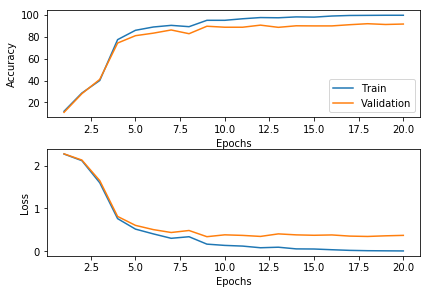

In [8]:
history.display()

Finalement, évaluons les performances du modèle sur le jeu de données de test.

In [9]:
score, loss = validate(model, test_set)
print(score)

92.8385416667


## Différences CPU - GPU

Pour faire exécuter le code sur GPU, il faut déplacer le model, les inputs et les targets sur le GPU.

In [10]:
model_gpu = MnistNet()
model_gpu.cuda()

MnistNet (
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear (2450 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

Comparons le temps d'exécution sur CPU et sur GPU

Pour ce faire, nous utiliserons MNIST au complet

In [11]:
train_set = Dataset(mnist[:40000])
val_set = Dataset(mnist[40000:])

In [12]:
epoch = 5
batch_size = 256
lr = 0.1

Pendant l'entraînement, vérifier l'utilisation du CPU avec la commande htop.

In [14]:
print('Training on CPU')
model = MnistNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

start_cpu = time.time()
history = train(model, epoch, batch_size, lr)
end_cpu = time.time()

cpu_time = end_cpu - start_cpu

Training on CPU
Epoch 0 - Train acc: 82.77 - Val acc: 83.53 - Train loss: 0.4870 - Val loss: 0.4718
Epoch 1 - Train acc: 93.91 - Val acc: 93.89 - Train loss: 0.1965 - Val loss: 0.1964
Epoch 2 - Train acc: 95.87 - Val acc: 95.38 - Train loss: 0.1324 - Val loss: 0.1423
Epoch 3 - Train acc: 96.29 - Val acc: 95.91 - Train loss: 0.1144 - Val loss: 0.1265
Epoch 4 - Train acc: 96.93 - Val acc: 96.46 - Train loss: 0.0956 - Val loss: 0.1143


Pour vous assurer que le réseau entraîne bien sur GPU, utiliser la commande 

watch -n 1 nvidia-smi 

Observer l'utilisation de la carte et la quantité de mémoire utilisée pendant l'entraînement.

In [17]:
print('Training on GPU')
model_gpu = MnistNet()
model_gpu.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_gpu.parameters(), lr=lr)

start_gpu = time.time()
history_gpu = train(model_gpu, epoch, batch_size, lr, use_gpu=True)
end_gpu = time.time()

gpu_time = end_gpu - start_gpu

Training on GPU
Epoch 0 - Train acc: 67.26 - Val acc: 67.94 - Train loss: 0.9635 - Val loss: 0.9407
Epoch 1 - Train acc: 93.18 - Val acc: 93.09 - Train loss: 0.2307 - Val loss: 0.2294
Epoch 2 - Train acc: 95.67 - Val acc: 95.28 - Train loss: 0.1404 - Val loss: 0.1510
Epoch 3 - Train acc: 96.82 - Val acc: 96.25 - Train loss: 0.1033 - Val loss: 0.1194
Epoch 4 - Train acc: 96.99 - Val acc: 96.59 - Train loss: 0.0929 - Val loss: 0.1115


In [18]:
print('CPU - Training time: {:.2f}s'.format(cpu_time))
print('GPU - Training time: {:.2f}s'.format(gpu_time))
print('Ratio: {:.2f}x'.format((cpu_time) / (gpu_time)))

CPU - Training time: 165.42s
GPU - Training time: 21.44s
Ratio: 7.71x


## CIFAR 10

CIFAR-10 est un jeu de données comportant des images séparés en 10 classe:<br>
0 - Avion<br>
1 - Voiture<br>
2 - Oiseau<br>
3 - Chat<br>
4 - Chevreuil<br>
5 - Chien<br>
6 - Grenouille<br>
7 - Cheval<br>
8 - Bateau<br>
9 - Camion<br>

Le jeu de données contient 50000 images d'entraînement. Nous en utiliserons 40000 pour l'entraînement et 10000 pour la validation.

In [19]:
cifar = load_cifar10()
train_set = Dataset(cifar[:40000])
val_set = Dataset(cifar[40000:])
test_set = load_cifar10(train=False)

Encore une fois, vous pouvez exécuter cette cellule plusieurs fois pour visualiser le jeu de données.

Target = 8


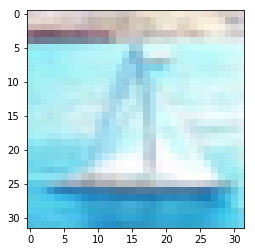

In [27]:
i = random.randrange(0, len(train_set))
img, target = train_set[i]
plt.imshow(np.asarray(img))
print('Target = {}'.format(target))

### Exercices

Utilisez les 3 cellules suivantes pour répondre aux questions.

In [33]:
epoch = 5
batch_size = 64
lr = 0.1

model= CifarNet()
model.cuda()

history = train(model, epoch, batch_size, lr, use_gpu=True)

Epoch 0 - Train acc: 9.95 - Val acc: 10.23 - Train loss: 2.3042 - Val loss: 2.3038
Epoch 1 - Train acc: 9.95 - Val acc: 10.23 - Train loss: 2.3042 - Val loss: 2.3037
Epoch 2 - Train acc: 9.95 - Val acc: 10.24 - Train loss: 2.3042 - Val loss: 2.3037
Epoch 3 - Train acc: 9.95 - Val acc: 10.24 - Train loss: 2.3042 - Val loss: 2.3037
Epoch 4 - Train acc: 9.95 - Val acc: 10.22 - Train loss: 2.3042 - Val loss: 2.3037


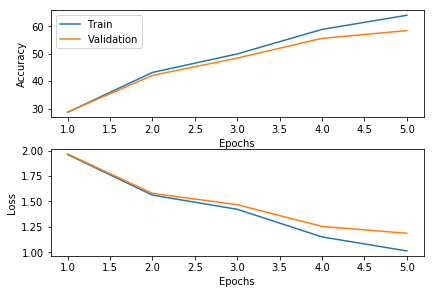

In [30]:
history.display()

In [31]:
score, loss = validate(model, test_set, use_gpu=True)
print(score)

58.4234775641


### Effet du nombre d'epochs

Modifier le nombre d'epochs et obverser les performances du réseau.

Que se passe-t-il s'il est trop grand?<br> 
S'il est trop petit?

### Effet de la taille de la batch

Modifier la taille de la batch et observer l'utilisation de la carte graphique.

Sur quoi est-ce que la taille de la batch semble avoir le plus d'impact?<br>
Est-ce qu'elle impacte les performances?<br>

### Effet du taux d'apprentissage (lr)

Encore une fois, observer l'impact du taux d'apprentissage sur l'entraînement.

Que se passe-t-il s'il est trop grand?<br> 
S'il est trop petit?

### Défi

Modifier les hyperparamètres pour améliorer les performances du réseau.<br>
Êtes-vous capable d'obtenir plus de 65% en test?